Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 64, 6, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_30 (Ba  (None, 64, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 31, 2, 32)         0         
 ng2D)                                                           
                                                     

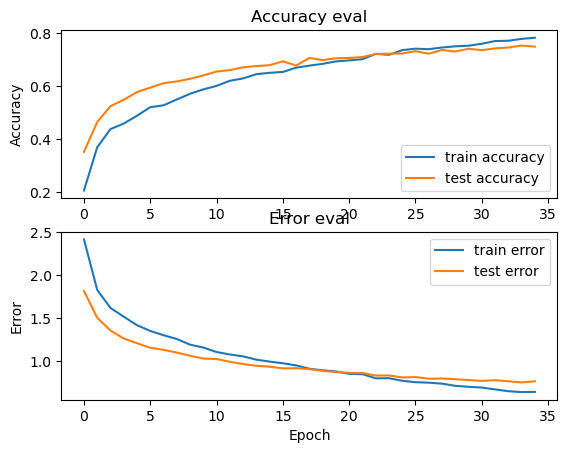

C:\Users\Lynnj\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 147ms/step
Target: 2, Predicted label: [2]
79/79 - 0s - loss: 0.7993 - accuracy: 0.7145 - 317ms/epoch - 4ms/step

Test accuracy: 0.7144573330879211
79/79 [==============================] - 0s 4ms/step
{'accuracy': 0.7144573488185822, 'precision': 0.7155193908943673, 'recall': 0.7155837194718414, 'f1_score': 0.7137477980408647, 'confusion_matrix': array([[172,   2,  22,   5,   6,   5,  11,   0,   4,  18],
       [  0, 250,   4,   0,   0,   7,   0,   0,   0,   0],
       [ 13,  10, 161,  14,   0,  16,   7,  10,   6,  30],
       [  9,   5,   7, 156,  19,   1,   3,  23,  13,  17],
       [  6,   2,   0,  13, 166,   0,  14,  13,  13,   2],
       [  4,  23,  19,   1,   0, 194,   0,   0,   0,   6],
       [  4,   0,   5,   0,   1,   2, 208,   0,   0,  22],
       [  0,   1,  15,   5,  22,   1,   0, 180,   9,   8],
       [  2,   2,  15,  21,  37,   5,   3,   8, 141,  12],
       [ 10,   5,  29,  23,   4,   9,  16,   1,  13, 156]], dtype=int64)}


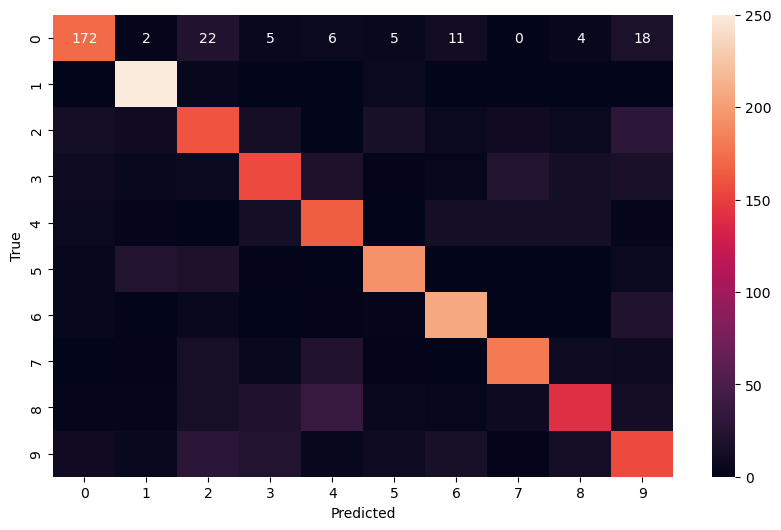

In [11]:
import json
import numpy as np
import seaborn as sn  
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

DATA_PATH = "data_10.json"

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    X, y = load_data(DATA_PATH)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print("Target: {}, Predicted label: {}".format(y, predicted_index))

if __name__ == "__main__":

    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=35, callbacks=[early_stopping])

    plot_history(history)

    model.save('genre_CLASS5.h5')

    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
    
    predict(model, X_to_predict, y_to_predict)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
y_pred = np.argmax(model.predict(X_test), axis=1)
all_metrics = calculate_metrics(y_test, y_pred)
print(all_metrics)

confusion_mtx = all_metrics['confusion_matrix']
plt.figure(figsize=(10, 6))  # Adjust figure size as needed 
sn.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
